## ResFPN Classifier Tutorial - Flower Photos

by *Ming Ming Zhang*

In [1]:
import tensorflow as tf
print('TF Version:', tf.__version__)
#print('GPUs:', len(tf.config.list_physical_devices('GPU')))

import numpy as np
import matplotlib.pyplot as plt
import os, sys

TF Version: 2.3.1


In [2]:
# python files directory
PY_DIR = #'directory/to/python/files'
sys.path.append(PY_DIR)

import resnet_fpn

## Data Info

In [3]:
# dataset directory
DATASET_DIR = #'directory/to/covidx'

In [4]:
TRAIN_NUM_IMGS = {}

print('-----Training Set Info-----')
for class_name in os.listdir(DATASET_DIR):
    if class_name == 'LICENSE.txt':
        continue
    imgs_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    num_imgs = len(imgs_list)
    TRAIN_NUM_IMGS[class_name] = num_imgs
    print('%s: %d images' % (class_name, num_imgs))

-----Training Set Info-----
daisy: 633 images
dandelion: 898 images
roses: 641 images
sunflowers: 699 images
tulips: 799 images


### TF Dataset

In [5]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True, 
    seed=123, 
    validation_split=0.1, 
    subset='training'
)

for x_train_batch, y_train_batch in train_ds.take(1):
    print(x_train_batch.shape, y_train_batch.shape)

Found 3670 files belonging to 5 classes.
Using 3303 files for training.
(32, 256, 256, 3) (32,)


In [7]:
CLASS_NAMES = train_ds.class_names
print('classes:', CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)

classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True, 
    seed=123, 
    validation_split=0.1, 
    subset='validation'
)

for x_val_batch, y_val_batch in val_ds.take(1):
    print(x_val_batch.shape, y_val_batch.shape)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.
(32, 256, 256, 3) (32,)


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(1)
val_ds = val_ds.cache().prefetch(1)

#### Visualization

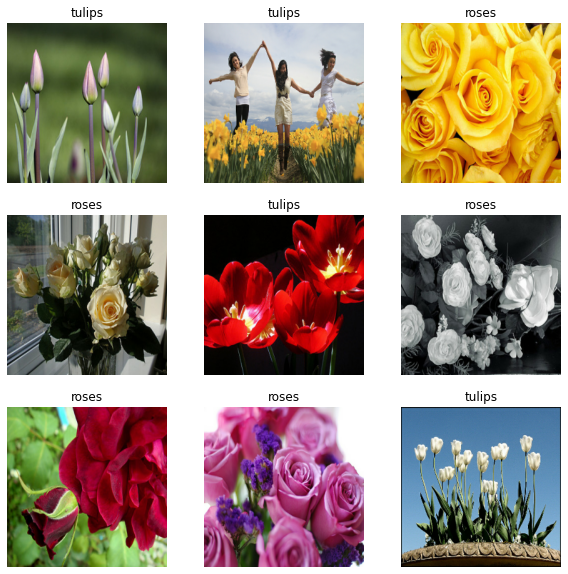

In [10]:
plt.figure(figsize=(10, 10))
for x_train_batch, y_train_batch in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(tf.cast(x_train_batch[i], tf.int32))
        plt.title(CLASS_NAMES[y_train_batch[i]])
        plt.axis('off')

### ResFPN Classifiers

#### Without Pretrained ResNet Weights

In [11]:
ResFPN = resnet_fpn.ResFPN_Classifier(
    image_shape=IMAGE_SIZE + (3,), 
    num_classes=NUM_CLASSES, 
    num_filters=256, 
    architecture='resnet50', 
    augmentation=True,
    checkpoint_path=None,
    resnet_weights_path=None)

In [12]:
ResFPN.train(
    train_dataset=train_ds, 
    val_dataset=val_ds, 
    params={'lr':0.001, 'l2':0.3, 'epochs':5}, 
    loss_type='ce',
    save_weights=False)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104/104 [==============================] - ETA: 0s - loss: 24.4481 - dense_resnet_loss: 1.5010 - dense_fpn_2_loss: 1.8423 - dense_fpn_3_loss: 1.9282 - dense_fpn_4_loss: 1.7108 - dense_fpn_5_loss: 1.5164 - dense_resnet_accuracy: 0.3803 - dense_fpn_2_accuracy: 0.3757 - dense_fpn_3_accuracy: 0.3772 - dense_fpn_4_accuracy: 0.3636 - dense_fpn_5_accuracy: 0.3772WARNING:te

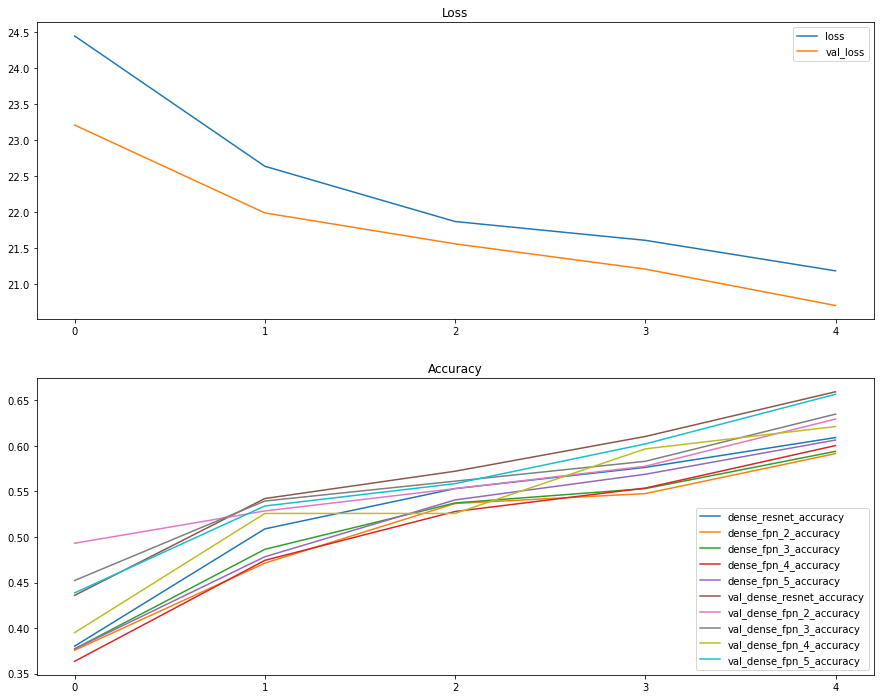

In [13]:
ResFPN.plot()

In [14]:
top_idxes, ensemble_acc = ResFPN.select_top(val_ds, top=3)

12/12 [==============================] - 1s 92ms/step - loss: 20.7059 - dense_resnet_loss: 0.9086 - dense_fpn_2_loss: 0.9809 - dense_fpn_3_loss: 0.9802 - dense_fpn_4_loss: 0.9678 - dense_fpn_5_loss: 0.9188 - dense_resnet_accuracy: 0.6594 - dense_fpn_2_accuracy: 0.6294 - dense_fpn_3_accuracy: 0.6349 - dense_fpn_4_accuracy: 0.6213 - dense_fpn_5_accuracy: 0.6567

Top classifiers: ['resnet', 'res_fpn_5', 'res_fpn_4']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf

In [15]:
ensemble_class_ids, metrics, f1_score = ResFPN.predict(
    val_ds, CLASS_NAMES, display_metrics=True, top_idxes=top_idxes)


Test accuracy: 0.65

daisy:
  precision 0.62, recall 0.33, F1-score 0.42
dandelion:
  precision 0.70, recall 0.38, F1-score 0.48
roses:
  precision 0.51, recall 0.28, F1-score 0.34
sunflowers:
  precision 0.81, recall 0.36, F1-score 0.49
tulips:
  precision 0.63, recall 0.32, F1-score 0.42

Average:
  precision 0.65, recall 0.33, F1-score 0.43


#### With Pretrained ResNet Weights

In [16]:
filepath = #'path\to\pretrained_resnet_weights.h5'

In [17]:
pretrain_ResFPN = resnet_fpn.ResFPN_Classifier(
    image_shape=IMAGE_SIZE + (3,), 
    num_classes=NUM_CLASSES, 
    num_filters=256, 
    architecture='resnet50', 
    augmentation=True,
    checkpoint_path=None,
    resnet_weights_path=filepath)

In [18]:
pretrain_ResFPN.train(
    train_dataset=train_ds, 
    val_dataset=val_ds, 
    params={'lr':0.001, 'l2':0.3, 'epochs':5}, 
    loss_type='ce',
    save_weights=False)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104/104 [==============================] - ETA: 0s - loss: 34.5103 - dense_resnet_loss: 0.5941 - dense_fpn_2_loss: 0.7492 - dense_fpn_3_loss: 0.6582 - dense_fpn_4_loss: 0.6420 - dense_fpn_5_loss: 0.5571 - dense_resnet_accuracy: 0.7748 - dense_fpn_2_accuracy: 0.7496 - dense_fpn_3_accuracy: 0.7735 - dense_fpn_4_accuracy: 0.7760 - dense_fpn_5_accuracy: 0.7893WARNING:te

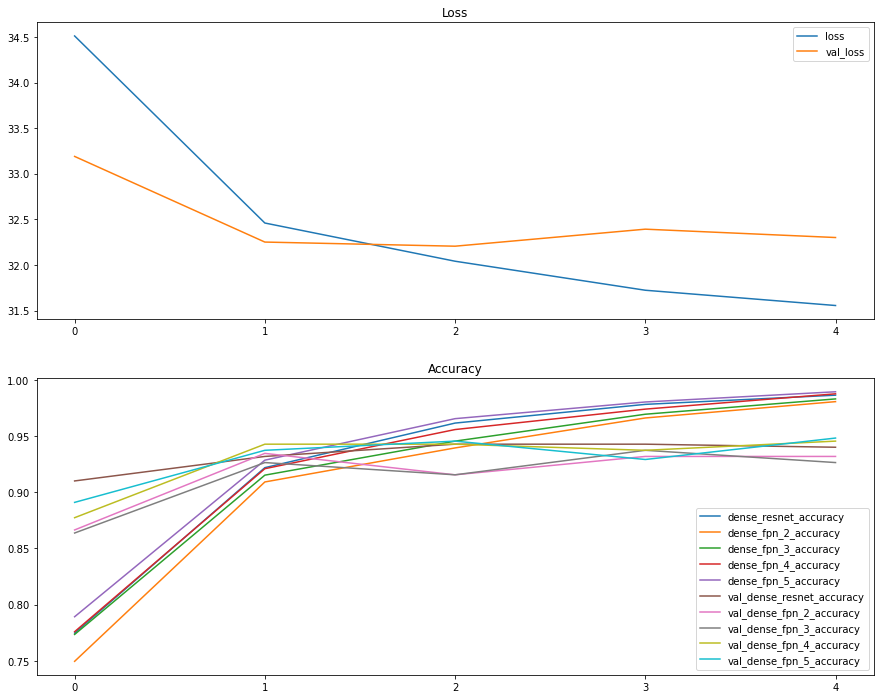

In [19]:
pretrain_ResFPN.plot()

In [20]:
top_idxes, val_acc = pretrain_ResFPN.select_top(val_ds, top=3)

12/12 [==============================] - 1s 98ms/step - loss: 32.3006 - dense_resnet_loss: 0.1455 - dense_fpn_2_loss: 0.2313 - dense_fpn_3_loss: 0.2294 - dense_fpn_4_loss: 0.1913 - dense_fpn_5_loss: 0.1935 - dense_resnet_accuracy: 0.9401 - dense_fpn_2_accuracy: 0.9319 - dense_fpn_3_accuracy: 0.9264 - dense_fpn_4_accuracy: 0.9455 - dense_fpn_5_accuracy: 0.9482

Top classifiers: ['resnet', 'res_fpn_4', 'res_fpn_5']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf

In [21]:
ensemble_class_ids, metrics, f1_score = pretrain_ResFPN.predict(
    val_ds, CLASS_NAMES, display_metrics=True, top_idxes=top_idxes)


Test accuracy: 0.95

daisy:
  precision 0.98, recall 0.80, F1-score 0.88
dandelion:
  precision 0.99, recall 0.84, F1-score 0.91
roses:
  precision 0.87, recall 0.82, F1-score 0.84
sunflowers:
  precision 0.99, recall 0.82, F1-score 0.89
tulips:
  precision 0.89, recall 0.89, F1-score 0.88

Average:
  precision 0.95, recall 0.84, F1-score 0.88
